# Module 7: 特徵選擇 - 2. 包裹法 (Wrapper Methods)

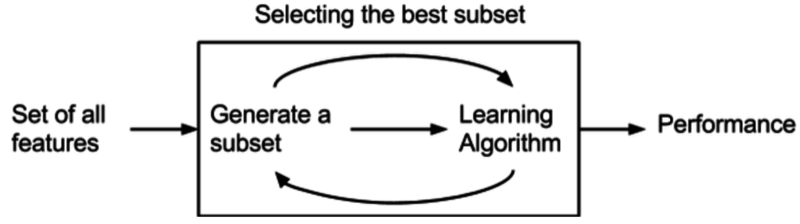

## 學習目標
- 理解包裹法原理：掌握包裹法如何透過模型效能來選擇特徵。
- 學習前向特徵選擇 (SFS)：實作並理解其從無到有逐步添加特徵的機制。
- 學習後向特徵消除 (BFE)：實作並理解其從全集逐步移除特徵的機制。
- 掌握遞歸特徵消除 (RFE/RFECV)：實作並理解其基於特徵重要性迭代篩選的機制。
- 比較不同包裹法的優缺點：了解各方法的計算成本、特徵交互處理能力及應用場景。

## 導論：模型如何「親自」參與特徵選擇？

您的指南提到：「*包裹法會將特徵選擇問題看作是一個搜尋問題，利用一個預測模型對特徵子集進行訓練和評估，從而決定哪些特徵應該被保留。*」這就是包裹法的核心思想。它將模型的性能作為特徵子集好壞的直接衡量標準，而非像過濾法那樣僅依賴統計量。

### 包裹法的優點與缺點

- **優點**:
  - **高相關性**: 由於直接針對特定模型的效能進行優化，選出的特徵與該模型的預測能力高度相關。
  - **考慮特徵交互**: 包裹法能夠評估特徵之間的組合效應，這是過濾法難以做到的。

- **缺點**:
  - **計算成本高**: 需要重複訓練模型，當特徵數量龐大時，計算成本非常高昂。這使得它在大規模資料集上應用受限。
  - **容易過擬合**: 如果評估指標選擇不當或資料集太小，可能會選出僅在訓練集上表現良好的特徵，導致模型在未知數據上泛化能力差。

---

## 常用包裹法技術

1. **前向特徵選擇 (Step Forward Feature Selection, SFS)**
2. **後向特徵消除 (Backward Feature Elimination, BFE)**
3. **遞歸特徵消除 (Recursive Feature Elimination, RFE)**

# 特徵選擇方法總結

以下是 **Successive Forward Selection (SFS)** 和 **Successive Backward Selection (SBS)** 的比較總結：

| 特徵選擇方法 | **Successive Forward Selection (SFS)** | **Successive Backward Selection (SBS)** |
|-------------------|-------------------------------------|-------------------------------------|
| **起始點**       | 開始於空的特徵集                       | 從完整的特徵集開始                     |
| **選擇方向**     | 逐步添加特徵                           | 逐步移除特徵                           |
| **算法目標**     | 添加特徵以最大化性能                   | 移除特徵以最小化性能損失               |
| **計算時間**     | 在初始選擇較少特徵時較快               | 由於完整特徵集，計算量較大             |
| **適用於特徵空間大小** | 適合小到中等的特徵空間               | 對於中等到大型特徵空間有效             |
| **局部最優風險** | 由於貪婪方法可能會錯過最佳子集         | 也有風險因移除關鍵特徵而導致次優選擇   |
| **內存使用**     | 低，因為初始存儲的特徵較少             | 高，因為載入了完整特徵集               |
| **典型用例**     | 在需要識別少量關鍵特徵的場景中有效，如生物信息學和信號處理 | 對於高維數據集（如圖像識別或文本處理）有用 |

## 總結

- **SFS** 更適合於需要識別少數關鍵特徵的情況，通常在特徵數量較少的情況下表現良好。
- **SBS** 則適合於特徵數量較多的情況，尤其是在高維數據集中，能夠有效地去除不必要的特徵。

選擇合適的方法取決於具體的數據集特性及需求。

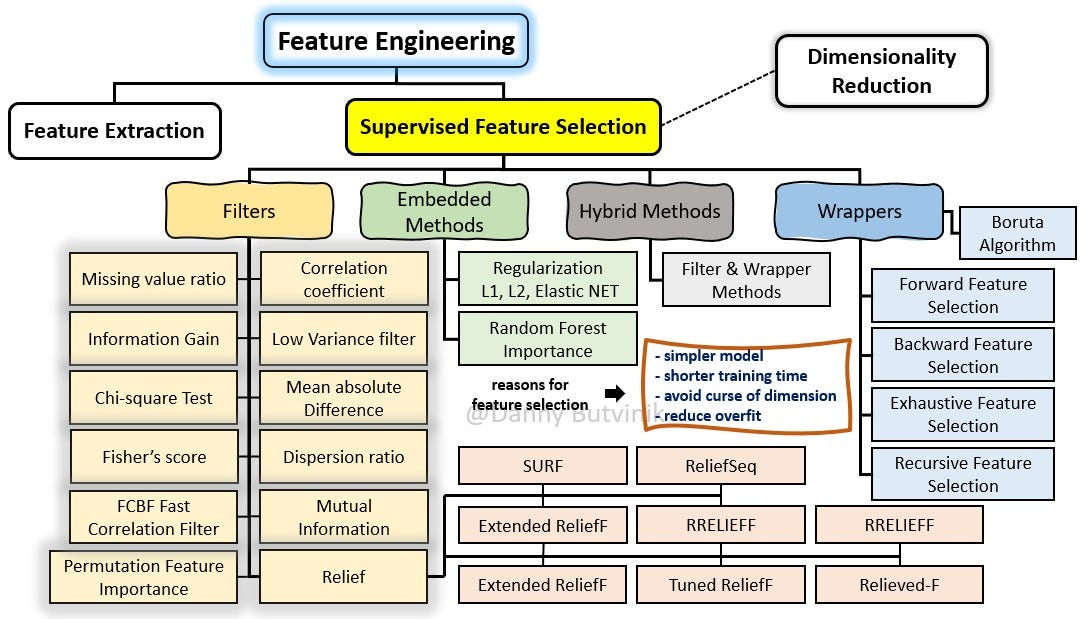

[ref](https://www.mdpi.com/2077-0472/10/9/400)


現在，我們將使用 `mlxtend` 和 `scikit-learn` 套件來實作這些方法。

---

## 1. 載入套件與資料

我們將使用 `scikit-learn` 內建的糖尿病資料集來示範。這個資料集包含 10 個基準線變數、年齡、性別、BMI、平均血壓和六種血清測量值，以及一年後疾病進展的定量指標。

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 設定視覺化風格
sns.set_style('whitegrid')

# 載入糖尿病資料集
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name='target')

# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("資料載入與切分完成！")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# 顯示前五筆資料
print("\nX_train 前五筆：")
display(X_train.head())



資料載入與切分完成！
X_train shape: (353, 10)
X_test shape: (89, 10)

X_train 前五筆：


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
17,0.070769,0.050680,0.012117,0.056301,0.034206,0.049416,-0.039719,0.034309,0.027364,-0.001078
66,-0.009147,0.050680,-0.018062,-0.033213,-0.020832,0.012152,-0.072854,0.071210,0.000272,0.019633
137,0.005383,-0.044642,0.049840,0.097615,-0.015328,-0.016345,-0.006584,-0.002592,0.017036,-0.013504
245,-0.027310,-0.044642,-0.035307,-0.029770,-0.056607,-0.058620,0.030232,-0.039493,-0.049872,-0.129483
31,-0.023677,-0.044642,-0.065486,-0.081413,-0.038720,-0.053610,0.059685,-0.076395,-0.037129,-0.042499


## 2. 前向特徵選擇 (Step Forward Feature Selection - SFS)

前向選擇從一個空集合開始，每次迭代都從剩餘的特徵中選擇一個能最大程度提升模型效能的特徵加入子集，直到達到預設的特徵數量或模型效能不再顯著提升為止。

**優點**：概念直觀，計算成本相對後向消除低。
**缺點**：容易陷入局部最優，一旦加入的特徵就不能移除，可能錯過最佳的特徵組合。

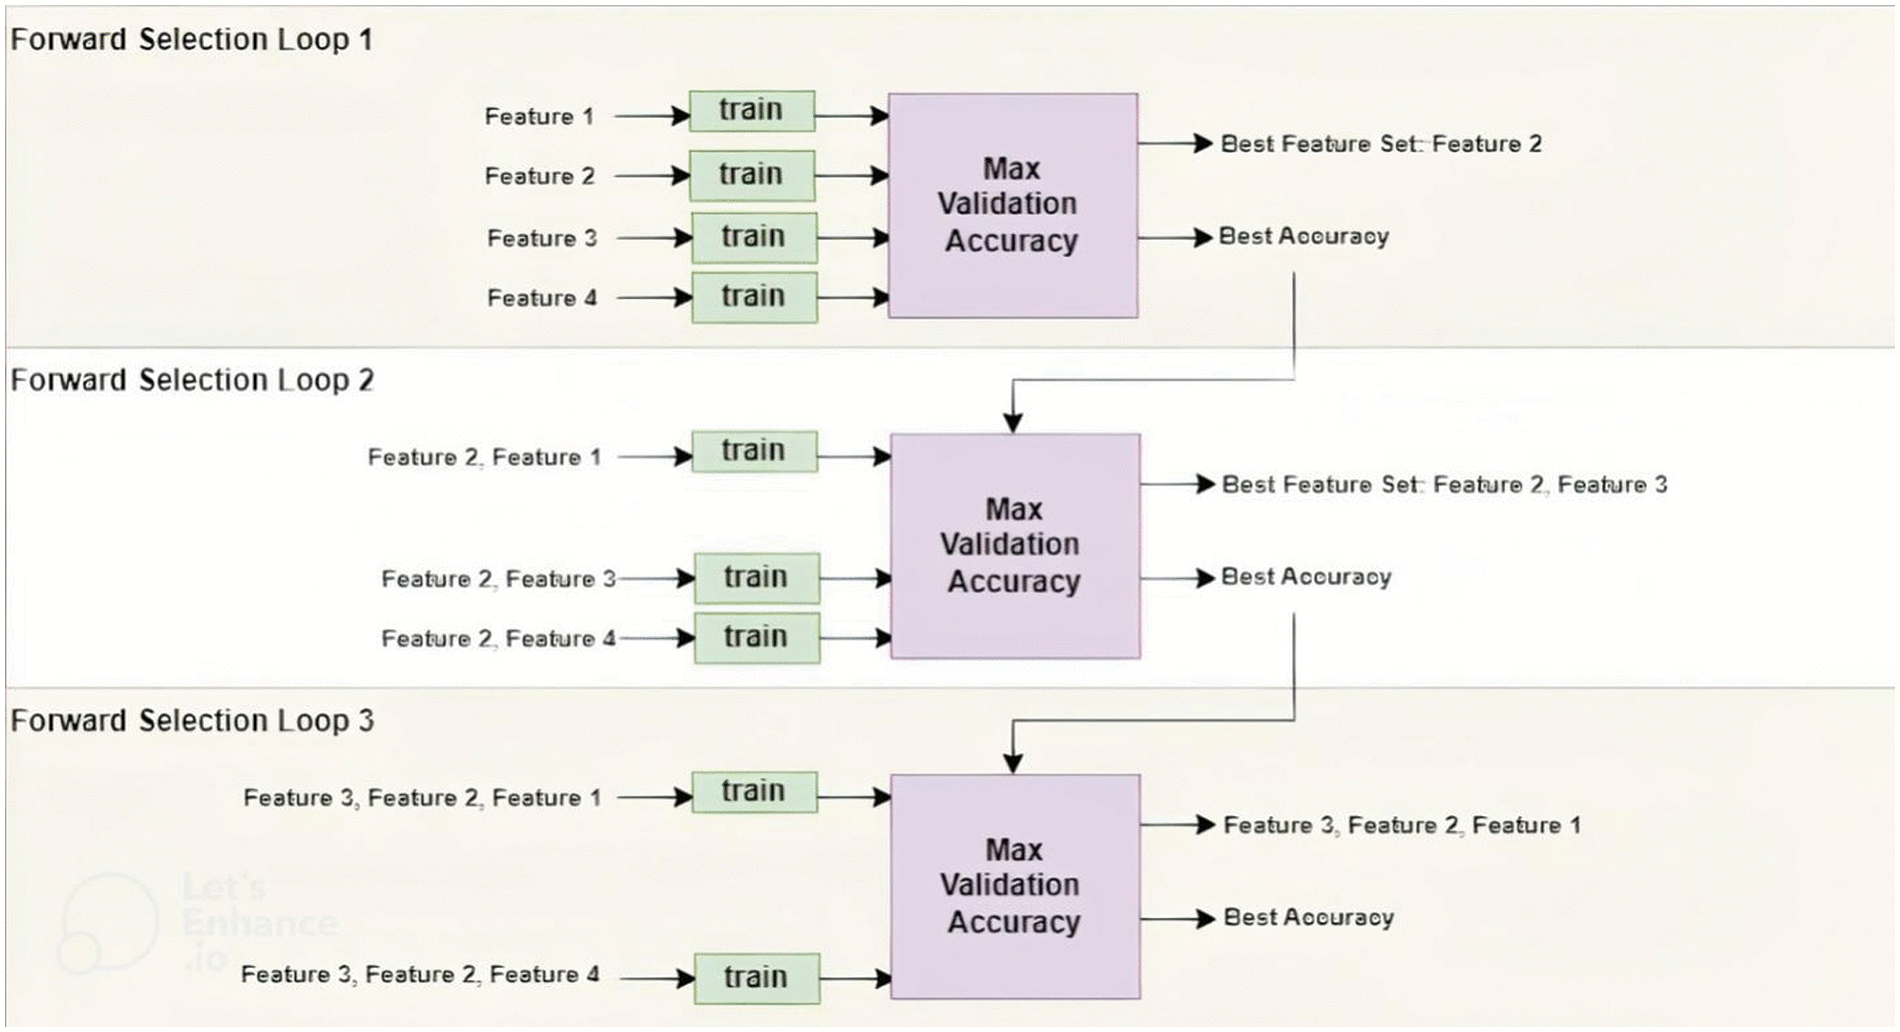

In [ ]:
# 初始化隨機森林回歸模型
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 初始化前向選擇器
# k_features='best' 會自動找到最佳特徵數
sfs = SFS(estimator=rf, 
          k_features='best', # 可以設定為(1, X_train.shape[1])來搜尋最佳特徵數
          forward=True, 
          floating=False, # 是否允許特徵在加入後被移除 (用於浮動選擇)
          scoring='r2', # 評估指標
          cv=3, # 交叉驗證折數
          n_jobs=-1) # 使用所有可用的CPU核心

print("正在執行前向特徵選擇，這可能需要一些時間...")
# 訓練選擇器
sfs = sfs.fit(X_train, y_train)

print("前向特徵選擇完成！")



正在執行前向特徵選擇，這可能需要一些時間...
前向特徵選擇完成！


**結果解讀**：

訓練完成後，我們可以查看 SFS 選擇的最佳特徵子集及其對應的模型效能分數。`k_feature_names_` 屬性會返回所選特徵的名稱，而 `k_score_` 則表示該特徵子集在交叉驗證上的 R2 分數。

In [3]:
# 查看選擇的最佳特徵
selected_features_sfs = list(sfs.k_feature_names_)
print(f"SFS 選擇的最佳特徵 ({sfs.k_score_:.4f} R2 score):")
print(selected_features_sfs)

# 建立只包含選中特徵的資料集
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

# 使用選擇的特徵重新訓練模型並評估
rf_sfs = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sfs.fit(X_train_sfs, y_train)
y_pred_sfs = rf_sfs.predict(X_test_sfs)
r2_sfs = r2_score(y_test, y_pred_sfs)

print(f"\n使用SFS選擇的 {len(selected_features_sfs)} 個特徵，在測試集上的 R2 Score: {r2_sfs:.4f}")

# 比較所有特徵的效能
rf_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_full.fit(X_train, y_train)
y_pred_full = rf_full.predict(X_test)
r2_full = r2_score(y_test, y_pred_full)

print(f"使用全部 {X_train.shape[1]} 個特徵，在測試集上的 R2 Score: {r2_full:.4f}")



SFS 選擇的最佳特徵 (0.4185 R2 score):
['sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

使用SFS選擇的 9 個特徵，在測試集上的 R2 Score: 0.4400
使用全部 10 個特徵，在測試集上的 R2 Score: 0.4428


**討論**：

從結果可以看出，SFS 選擇了一個較小的特徵子集，但在測試集上的 R2 分數可能與使用所有特徵的模型接近甚至更優。這說明 SFS 成功地移除了冗餘或不重要的特徵，有助於提高模型的泛化能力。

## 3. 後向特徵消除 (Backward Feature Elimination - BFE)

後向消除從包含所有特徵的集合開始，每次迭代都移除一個對模型效能影響最小的特徵，直到達到預設的特徵數量。

**優點**：能考慮到所有特徵之間的交互作用，通常能找到更好的特徵子集。
**缺點**：計算成本非常高，因為每次迭代都要重新訓練模型，且從所有特徵開始。

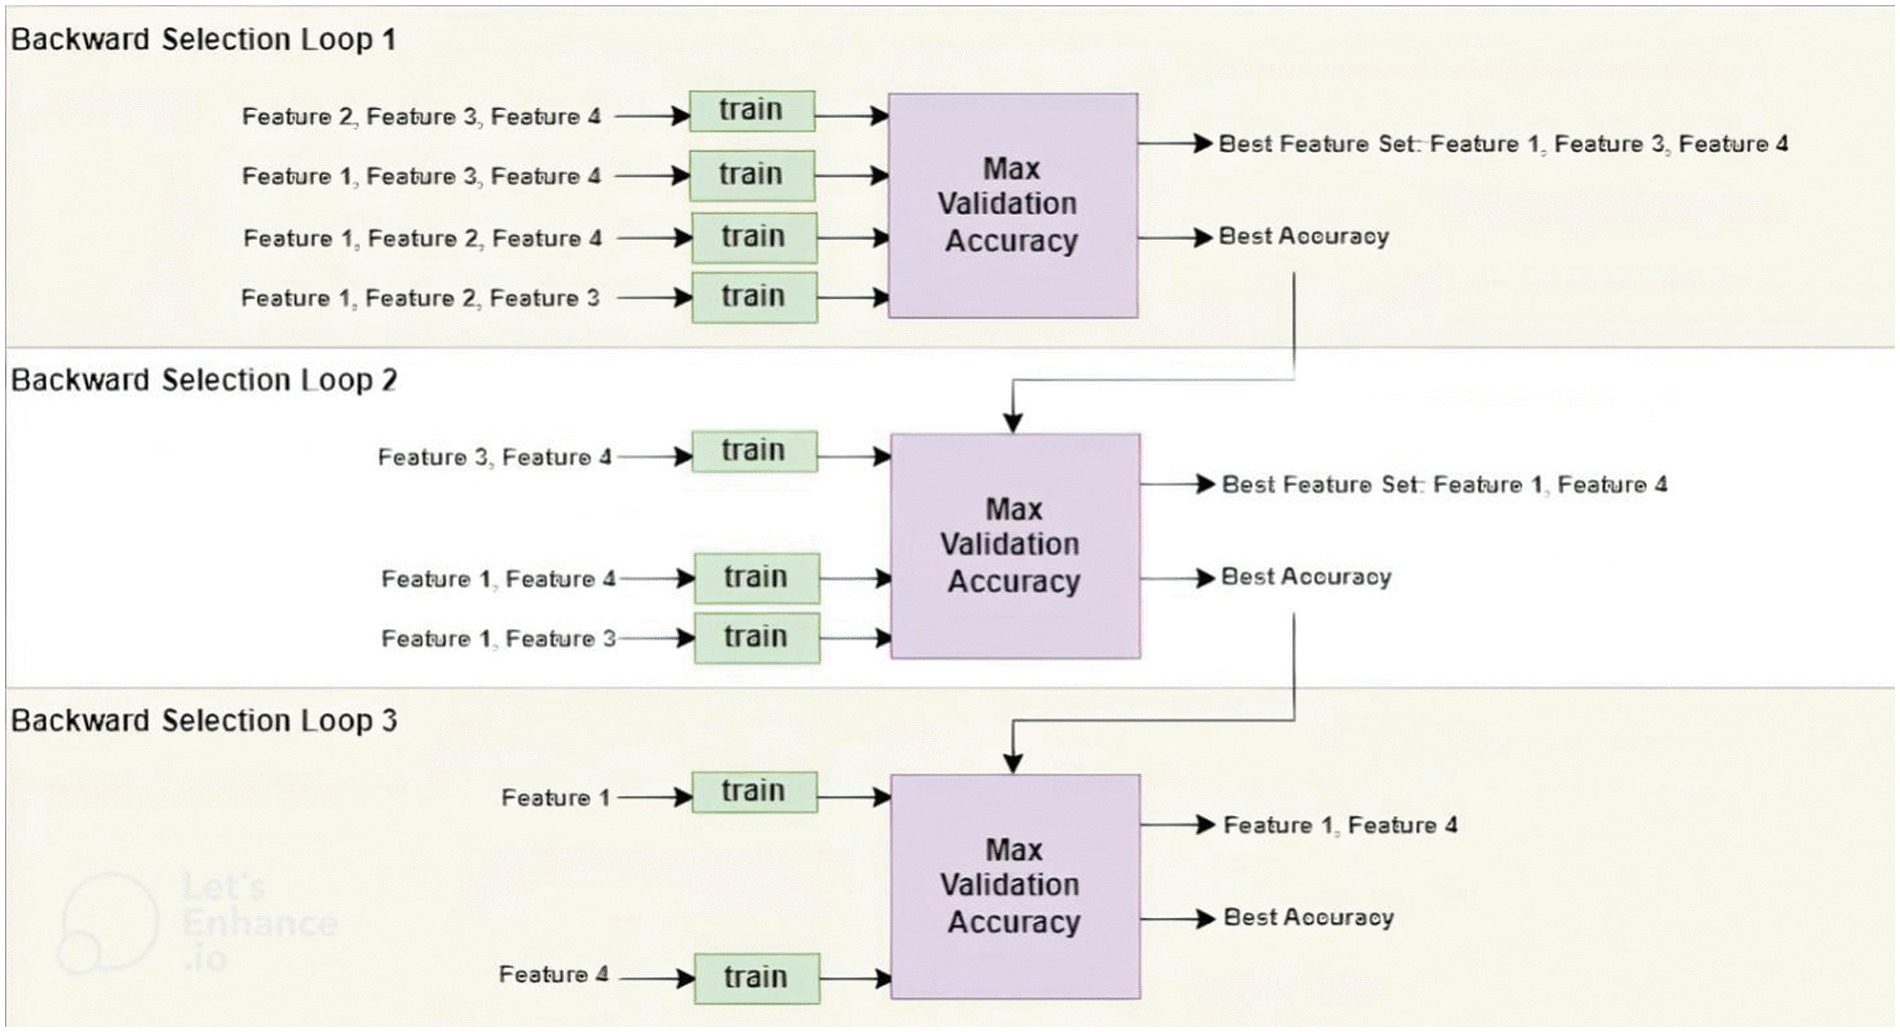

In [4]:
# 初始化後向消除器
# 同樣，我們讓它自動找到最佳特徵組合
sbs = SFS(estimator=rf, 
          k_features='best', # 尋找最佳特徵組合
          forward=False,      # backward=True
          floating=False, 
          scoring='r2',
          cv=3,
          n_jobs=-1)

print("正在執行後向特徵消除，這可能需要一些時間...")
# 訓練選擇器
sbs = sbs.fit(X_train, y_train)

print("後向特徵消除完成！")



正在執行後向特徵消除，這可能需要一些時間...


c:\Users\SUNNIE.GD.WENG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


後向特徵消除完成！


**結果解讀**：

類似於 SFS，我們查看 BFE 選擇的最佳特徵及其 R2 分數。

In [5]:
# 查看選擇的最佳特徵
selected_features_sbs = list(sbs.k_feature_names_)
print(f"BFE 選擇的最佳特徵 ({sbs.k_score_:.4f} R2 score):")
print(selected_features_sbs)

# 建立只包含選中特徵的資料集
X_train_sbs = sbs.transform(X_train)
X_test_sbs = sbs.transform(X_test)

# 使用選擇的特徵重新訓練模型並評估
rf_sbs = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sbs.fit(X_train_sbs, y_train)
y_pred_sbs = rf_sbs.predict(X_test_sbs)
r2_sbs = r2_score(y_test, y_pred_sbs)

print(f"\n使用BFE選擇的 {len(selected_features_sbs)} 個特徵，在測試集上的 R2 Score: {r2_sbs:.4f}")
print(f"使用全部 {X_train.shape[1]} 個特徵，在測試集上的 R2 Score: {r2_full:.4f}")



BFE 選擇的最佳特徵 (0.4252 R2 score):
['sex', 'bmi', 'bp', 's4', 's6']

使用BFE選擇的 5 個特徵，在測試集上的 R2 Score: 0.3382
使用全部 10 個特徵，在測試集上的 R2 Score: 0.4428


**討論**：

BFE 的結果通常會比 SFS 更優或持平，因為它在起始點考慮了所有特徵的上下文。然而，其高昂的計算成本是其主要缺點。

### 視覺化選擇過程

`mlxtend` 提供了便利的視覺化工具來展示特徵選擇過程中的效能變化。這有助於我們直觀地理解不同特徵數量下模型效能的趨勢。

<Figure size 800x600 with 0 Axes>

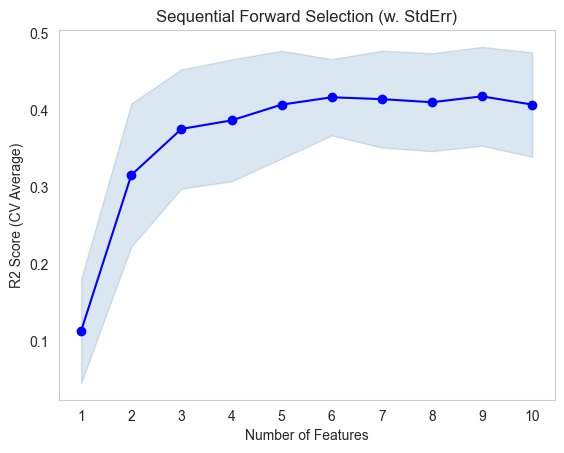

<Figure size 800x600 with 0 Axes>

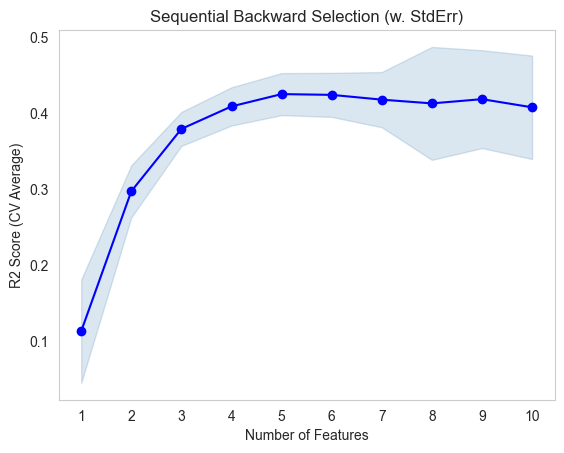

In [8]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

# SFS 圖表
plt.figure(figsize=(8, 6))
plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.ylabel('R2 Score (CV Average)')
plt.xlabel('Number of Features')
plt.grid()
plt.show()

# SBS 圖表
plt.figure(figsize=(8, 6))
plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection (w. StdErr)')
plt.ylabel('R2 Score (CV Average)')
plt.xlabel('Number of Features')
plt.grid()
plt.show()

**圖表解讀**：

這些圖表顯示了隨著選擇的特徵數量增加（SFS）或減少（BFE），模型在交叉驗證上的平均 R2 分數如何變化。陰影區域表示標準差。我們可以從圖中找到 R2 分數達到高峰的特徵數量，作為選擇最佳特徵數的參考。

## 4. 遞歸特徵消除 (Recursive Feature Elimination - RFE)

RFE 是一種更為複雜的包裹法。它首先用所有特徵訓練一個模型，然後根據特徵的重要性（例如，回歸係數或特徵重要性分數）移除最不重要的特徵。這個過程會不斷重複，直到剩下預定數量的特徵。

`scikit-learn` 提供了 `RFE` 和 `RFECV` (帶交叉驗證的RFE) 兩種實現。

**優點**：考慮了特徵間的相互作用和重要性，可以自動調整特徵數量。
**缺點**：計算成本仍然較高，且結果依賴於內部模型的特徵重要性計算穩定性。

In [9]:
from sklearn.feature_selection import RFE

# 初始化模型
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 初始化RFE
# n_features_to_select: 指定要選擇的特徵數量
# 我們可以先選擇一半的特徵，例如 5 個特徵
rfe = RFE(estimator=rf, n_features_to_select=5, step=1) # step=1 表示每次迭代移除一個特徵

print("正在執行 RFE...")
# 訓練RFE
rfe.fit(X_train, y_train)

print("RFE 完成！")



正在執行 RFE...
RFE 完成！


**結果解讀**：

RFE 會提供一個特徵排名，排名為 1 的特徵是被選中的。我們可以查看這些被選中的特徵以及所有特徵的排名。

In [10]:
# 查看RFE的選擇結果
selected_features_rfe = X_train.columns[rfe.support_]
print("RFE 選擇的特徵:")
print(selected_features_rfe.tolist())

# ranking_ 屬性顯示了特徵的排名，1表示被選中
print("\n特徵排名 (1表示被選中，數字越大重要性越低):")
rfe_ranking = pd.Series(rfe.ranking_, index=X_train.columns)
display(rfe_ranking.sort_values())

# 使用選擇的特徵進行評估
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

rf_rfe = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = rf_rfe.predict(X_test_rfe)
r2_rfe = r2_score(y_test, y_pred_rfe)

print(f"\n使用RFE選擇的 {len(selected_features_rfe)} 個特徵，在測試集上的 R2 Score: {r2_rfe:.4f}")
print(f"使用全部 {X_train.shape[1]} 個特徵，在測試集上的 R2 Score: {r2_full:.4f}")



RFE 選擇的特徵:
['bmi', 'bp', 's2', 's5', 's6']

特徵排名 (1表示被選中，數字越大重要性越低):


bmi    1
bp     1
s2     1
s5     1
s6     1
age    2
s3     3
s1     4
s4     5
sex    6
dtype: int32


使用RFE選擇的 5 個特徵，在測試集上的 R2 Score: 0.4187
使用全部 10 個特徵，在測試集上的 R2 Score: 0.4428


**討論**：

RFE 能夠根據模型內部的特徵重要性來進行選擇，這使得它在很多情況下表現出色。我們可以透過調整 `n_features_to_select` 來控制最終選出的特徵數量。

### 使用 RFECV 自動選擇最佳特徵數

`RFECV` 透過交叉驗證來自動尋找最佳的特徵數量，避免了手動設定 `n_features_to_select` 的麻煩。這是 RFE 的一個更實用的版本。

In [12]:
from sklearn.feature_selection import RFECV

# 初始化模型
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1) # 使用較少估計器加速，以便範例運行更快

# 初始化RFECV
# cv: 交叉驗證折數，用於評估不同特徵數量下的模型性能
# scoring: 評估指標，這裡使用R2分數
rfecv = RFECV(estimator=rf, 
              step=1, 
              cv=5, 
              scoring='r2',
              n_jobs=-1)

print("正在執行 RFECV，這將自動尋找最佳特徵數量...")
# 訓練RFECV
rfecv.fit(X_train, y_train)

print("RFECV 完成！")



正在執行 RFECV，這將自動尋找最佳特徵數量...
RFECV 完成！


**結果解讀**：

RFECV 會告訴我們它認為最佳的特徵數量，並提供每個特徵的 `support_` 屬性來標示是否被選中。最重要的是，我們可以透過繪製交叉驗證分數圖來觀察模型性能隨特徵數量的變化。

RFECV 找到的最佳特徵數量: 10

RFECV 選擇的最佳特徵:
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


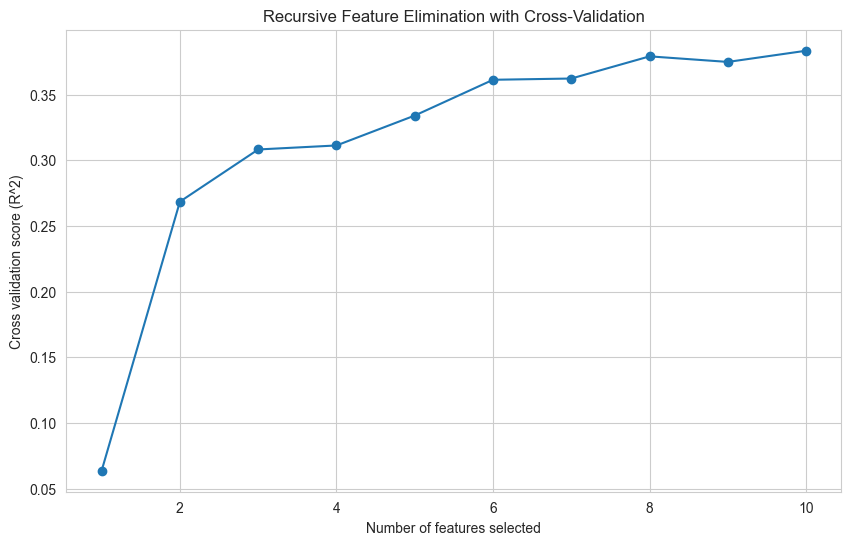


使用RFECV選擇的 10 個特徵，在測試集上的 R2 Score: 0.4254
使用全部 10 個特徵，在測試集上的 R2 Score: 0.4428


In [13]:
# RFECV 結果
print(f"RFECV 找到的最佳特徵數量: {rfecv.n_features_}")

selected_features_rfecv = X_train.columns[rfecv.support_]
print("\nRFECV 選擇的最佳特徵:")
print(selected_features_rfecv.tolist())

# 視覺化交叉驗證分數
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (R^2)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.title("Recursive Feature Elimination with Cross-Validation")
plt.grid(True)
plt.show()

# 使用RFECV選擇的特徵進行最終評估
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)

# 這裡我們可以直接使用已經訓練好的rfecv.estimator_來對原始X_test進行預測 (因為rfecv內部會處理轉換)
y_pred_rfecv = rfecv.predict(X_test) 
r2_rfecv = r2_score(y_test, y_pred_rfecv)

print(f"\n使用RFECV選擇的 {rfecv.n_features_} 個特徵，在測試集上的 R2 Score: {r2_rfecv:.4f}")
print(f"使用全部 {X_train.shape[1]} 個特徵，在測試集上的 R2 Score: {r2_full:.4f}")



**討論**：

RFECV 圖表清楚地展示了模型性能如何隨著特徵數量的增加而變化。我們可以從圖中找到最佳的特徵數量，即 R2 分數達到最高的點。在很多情況下，特徵數量較少但性能相近的子集是更優的選擇。

## 5. 總結

在這個筆記本中，我們探討並實作了三種主要的包裹法特徵選擇技術：

1.  **前向特徵選擇 (SFS)**: 從零開始，逐步加入最有用的特徵。優點是概念直觀，計算成本相對較低（相對於從所有特徵開始的方法）。缺點是可能陷入局部最優。
2.  **後向特徵消除 (BFE)**: 從全部特徵開始，逐步移除最無用的特徵。優點是能評估特徵組合的整體效果。缺點是計算成本非常高。
3.  **遞歸特徵消除 (RFE/RFECV)**: 透過模型的特徵重要性，迭代地移除特徵。優點是考慮了特徵間的相互作用和重要性，並且 RFECV 能自動找到最佳特徵數量。缺點是計算成本仍然較高，且結果依賴於模型的穩定性。

| 方法 | 優點 | 缺點 |
|:---|:---|:---|
| **SFS** | 計算成本相對較低（與BFE相比），直觀 | 可能陷入局部最優，錯過特徵組合 |
| **BFE** | 能評估特徵組合的整體效果，考慮所有特徵上下文 | 計算成本非常高，速度慢 |
| **RFE/RFECV**| 考慮了特徵間的相互作用和重要性，RFECV可自動優化特徵數量 | 計算成本高，且結果依賴於模型的穩定性 |

包裹法雖然計算成本較高，但由於其直接與模型效能掛鉤，通常能找到比過濾法更好的特徵子集。在實際應用中，可以先使用過濾法進行初步篩選，再用包裹法進行精細選擇，以平衡效果與效率。